# Imports and configs

In [1]:
!pip install -q scikit-learn==1.5.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0 requires google-cloud-bigquery[bqstorage,pandas]>=3.10.0, but you have google-cloud-bigquery 2.34.4 which is incompatible.
bigframes 0.22.0 requires google-cloud-storage>=2.0.0, but you have google-cloud-storage 1.44.0 which is incompatible.
bigframes 0.22.0 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.3 which is incompatible.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dataproc-jupyter-plugin 0.1.79 requires pydantic~=1.10.0, but you have pydantic 2.10.2 which is incompatible.


In [2]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.base import clone
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import shutil
import optuna
import json
import glob
import ydf
import os
import gc

ydf.verbose(2)
warnings.filterwarnings("ignore")

In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s4e12/train.csv"
    test_path = "/kaggle/input/playground-series-s4e12/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s4e12/sample_submission.csv"
    
    target = "Premium Amount"
    metric = "RMSLE"
    n_folds = 5
    seed = 42

    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
def get_data(model):
    train = pd.read_csv(CFG.train_path, index_col="id")
    test = pd.read_csv(CFG.test_path, index_col="id")
    
    train["Policy Start Date"] = pd.to_datetime(train["Policy Start Date"])
    test["Policy Start Date"] = pd.to_datetime(test["Policy Start Date"])
    train["Year"] = train["Policy Start Date"].dt.year
    test["Year"] = test["Policy Start Date"].dt.year
    train.drop("Policy Start Date", axis=1, inplace=True)
    test.drop("Policy Start Date", axis=1, inplace=True)

    cat_cols = test.select_dtypes(include="object").columns.tolist()
    train[cat_cols] = train[cat_cols].astype(str).astype("category")
    test[cat_cols] = test[cat_cols].astype(str).astype("category")

    if model in ["histgb"]:
        encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        train[cat_cols] = encoder.fit_transform(train[cat_cols])
        test[cat_cols] = encoder.transform(test[cat_cols])

    X = train.drop(CFG.target, axis=1)
    y = np.log1p(train[CFG.target])
    X_test = test

    return X, y, X_test

# Training base models

In [5]:
class Trainer:
    def __init__(self, model, config=CFG):
        self.model = model
        self.config = config
        
    def train(self, X, y, X_test, model_name):       
        print(f"Training {self.model.__class__.__name__}\n")
                
        scores = []
        oof_preds = np.zeros(X.shape[0])
        test_preds = np.zeros(X_test.shape[0])
        coeffs = np.zeros((1, X.shape[1]))
        
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            y_preds, temp_test_preds, score, _coeff = self._fit_predict(fold_idx, X_train, y_train, X_val, y_val, X_test)
            oof_preds[val_idx] = y_preds
            test_preds += temp_test_preds / self.config.n_folds
            scores.append(score)
            if _coeff is not None:
                coeffs += _coeff / self.config.n_folds
            
            del X_train, y_train, X_val, y_val, y_preds, temp_test_preds
            gc.collect() 
            
        overall_score = root_mean_squared_error(y, np.maximum(oof_preds, 0))
        average_score = np.mean(scores)
        
        self._save_results(oof_preds, test_preds, overall_score, model_name)
        print(f"\n------ Overall {CFG.metric}: {overall_score:.6f} - Average {CFG.metric}: {average_score:.6f}")
        
        return oof_preds, test_preds, scores, coeffs
    
    def tune(self, X, y):       
        scores = []
        split = KFold(n_splits=self.config.n_folds, random_state=self.config.seed, shuffle=True).split(X, y)
        for fold_idx, (train_idx, val_idx) in enumerate(split):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_preds = model.predict(X_val)
            score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
            scores.append(score)
            
            del X_train, y_train, X_val, y_val, y_preds
            gc.collect()
            
        return np.mean(scores)
        
    def _save_results(self, oof_preds, test_preds, cv_score, model_name):            
        if isinstance(self.model, (Ridge, Lasso)):
            pass
        else:
            prefix = model_name.replace("-", "_")
            os.makedirs(f"oof/{model_name}", exist_ok=True)
            
            with open(f"oof/{model_name}/{prefix}_oof_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(oof_preds), f)
                
            with open(f"oof/{model_name}/{prefix}_test_preds_{cv_score:.6f}.pkl", "wb") as f:
                pickle.dump(np.expm1(test_preds), f)
            
    def _fit_predict(self, fold_idx, X_train, y_train, X_val, y_val, X_test):
        if isinstance(self.model, LGBMRegressor):
            y_preds, test_preds = self._fit_lightgbm(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, XGBRegressor):
            y_preds, test_preds = self._fit_xgboost(X_train, y_train, X_val, y_val, X_test)
        elif isinstance(self.model, CatBoostRegressor):
            y_preds, test_preds = self._fit_catboost(X_train, y_train, X_val, y_val, X_test)
        else:
            model = clone(self.model)
            model.fit(X_train, y_train)
            y_preds = model.predict(X_val)
            test_preds = model.predict(X_test)
            
        score = root_mean_squared_error(y_val, np.maximum(y_preds, 0))
        
        if isinstance(self.model, (CatBoostRegressor, LGBMRegressor, XGBRegressor)):
            print(f"\n--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}\n\n")
        else:
            print(f"--- Fold {fold_idx + 1} - {CFG.metric}: {score:.6f}")
            
        coeff = model.coef_ if isinstance(self.model, (Ridge, Lasso)) else None
        return y_preds, test_preds, score, coeff
        
    def _fit_lightgbm(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
            X_train, 
            y_train, 
            eval_metric="rmse",
            eval_set=[(X_val, y_val)], 
            callbacks=[
                log_evaluation(period=200), 
                early_stopping(stopping_rounds=100)
            ]
        )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_xgboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)
        model.fit(
                X_train, 
                y_train, 
                eval_set=[(X_val, y_val)], 
                verbose=200
            )
        
        y_preds = model.predict(X_val)
        test_preds = model.predict(X_test)
        del model
        
        return y_preds, test_preds
    
    def _fit_catboost(self, X_train, y_train, X_val, y_val, X_test):
        model = clone(self.model)

        cat_cols = X_train.select_dtypes(include="category").columns.tolist()
        if len(cat_cols) > 0:
            train_pool = Pool(X_train, y_train, cat_features=cat_cols)
            val_pool = Pool(X_val, y_val, cat_features=cat_cols)
            test_pool = Pool(X_test, cat_features=cat_cols)
        else:
            train_pool = Pool(X_train, y_train)
            val_pool = Pool(X_val, y_val)
            test_pool = Pool(X_test)

        model.fit(
            X=train_pool, 
            eval_set=val_pool, 
            verbose=200, 
            early_stopping_rounds=100,
            use_best_model=True
        )
        
        y_preds = model.predict(val_pool)
        test_preds = model.predict(test_pool)
        del model
        
        return y_preds, test_preds

In [6]:
def plot_results(y_preds, y, model_name):
    y = np.expm1(y)
    y_preds = np.expm1(y_preds)
    
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    sns.ecdfplot(y_preds, label="Predictions", ax=axes[0])
    sns.ecdfplot(y, label="Target", ax=axes[0])
    axes[0].set_title(f"{model_name} CDF")
    axes[0].legend(loc="best")
    axes[0].set_ylim(0, 1.1)

    sns.histplot(y_preds, kde=True, ax=axes[1], label='Predictions')
    sns.histplot(y, kde=True, ax=axes[1], label='Target')
    axes[1].set_title(f"{model_name} prediction and target distributions")
    axes[1].legend(loc="best")

    plt.tight_layout()
    plt.show()

In [7]:
def save_sub(name, test_preds, score):
    sub = pd.read_csv(CFG.sample_sub_path)
    sub[CFG.target] = np.expm1(test_preds)
    sub.to_csv(f"sub_{name}_{score:.6f}.csv", index=False)
    return sub

In [8]:
histgb_params = {
    "l2_regularization": 97.57932943804968,
    "learning_rate": 0.04240839552862035,
    "max_depth": 354,
    "max_features": 0.8247981165620517,
    "max_iter": 2310,
    "max_leaf_nodes": 97,
    "min_samples_leaf": 36,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.9872314257127408,
    "learning_rate": 0.05343422655561087,
    "min_child_samples": 63,
    "min_child_weight": 0.6687637013029941,
    "n_estimators": 5000,
    "n_jobs": -1,
    "num_leaves": 79,
    "random_state": 42,
    "reg_alpha": 13.597853416168482,
    "reg_lambda": 30.849379423298384,
    "subsample": 0.158082661630902,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.99540568767702,
    "learning_rate": 0.009551897950587227,
    "min_child_samples": 19,
    "min_child_weight": 0.011150633860352643,
    "n_estimators": 5000,
    "n_jobs": -1,
    "num_leaves": 82,
    "random_state": 42,
    "reg_alpha": 10.213340637119938,
    "reg_lambda": 60.86384994349396,
    "subsample": 0.9974198155466328,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.992856916206705,
    "colsample_bynode": 0.9544347759352364,
    "colsample_bytree": 0.9961529490270978,
    "early_stopping_rounds": 100,
    "enable_categorical": True,
    "eval_metric": "rmse",
    "gamma": 4.054739566104445,
    "learning_rate": 0.03889684314255277,
    "max_depth": 19,
    "max_leaves": 83,
    "min_child_weight": 23,
    "n_estimators": 5000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 83.07529157853307,
    "reg_lambda": 2.67831942399408,
    "subsample": 0.9438059983649152,
    "verbosity": 0
}

cb_params = {
    "border_count": 221,
    "colsample_bylevel": 0.7769024750363183,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 5000,
    "l2_leaf_reg": 13.06280331208708,
    "learning_rate": 0.08084212863274641,
    "min_child_samples": 50,
    "random_state": 42,
    "random_strength": 0.8965166707564866,
    "subsample": 0.8932974737961973,
    "verbose": False
}

ydf_params = {
    "num_trees": 1000,
    "max_depth": 8,
    **ydf.GradientBoostedTreesLearner.hyperparameter_templates()["better_defaultv1"]
}

In [9]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [10]:
X, y, X_test = get_data("histgb")
histgb_model = HistGradientBoostingRegressor(**histgb_params)
histgb_trainer = Trainer(histgb_model)
oof_preds["HistGB"], test_preds["HistGB"], scores["HistGB"], _ = histgb_trainer.train(X, y, X_test, "histgb")

Training HistGradientBoostingRegressor

--- Fold 1 - RMSLE: 1.046022
--- Fold 2 - RMSLE: 1.045078
--- Fold 3 - RMSLE: 1.046196
--- Fold 4 - RMSLE: 1.044151
--- Fold 5 - RMSLE: 1.045685

------ Overall RMSLE: 1.045427 - Average RMSLE: 1.045426


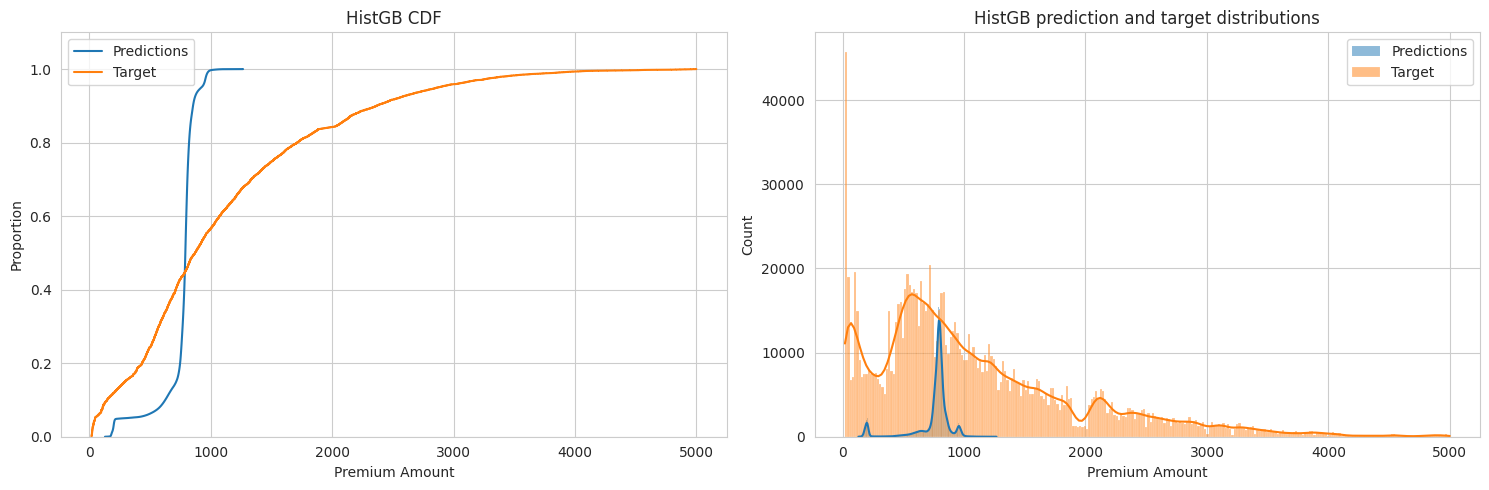

In [11]:
plot_results(oof_preds["HistGB"], y, "HistGB")

## LightGBM (GBDT)

In [12]:
X, y, X_test = get_data("lgbm-gbdt")
lgbm_model = LGBMRegressor(**lgbm_params)
lgbm_trainer = Trainer(lgbm_model)
oof_preds["LightGBM"], test_preds["LightGBM"], scores["LightGBM"], _ = lgbm_trainer.train(X, y, X_test, "lgbm-gbdt")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04594	valid_0's l2: 1.09399
Early stopping, best iteration is:
[209]	valid_0's rmse: 1.04592	valid_0's l2: 1.09395

--- Fold 1 - RMSLE: 1.045923


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04539	valid_0's l2: 1.09284
Early stopping, best iteration is:
[179]	valid_0's rmse: 1.04538	valid_0's l2: 1.09281

--- Fold 2 - RMSLE: 1.045376


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's rmse: 1.04636	valid_0's l2: 1.09488

--- Fold 3 - RMSLE: 1.046364


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.0438	valid_0's l2: 1.08952
Early stopping, best iteration is:
[191]	valid_0's rmse: 1.04379	valid_0's l2: 1.0895

--- Fold 4 - RMSLE: 1.043792


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04588	valid_0

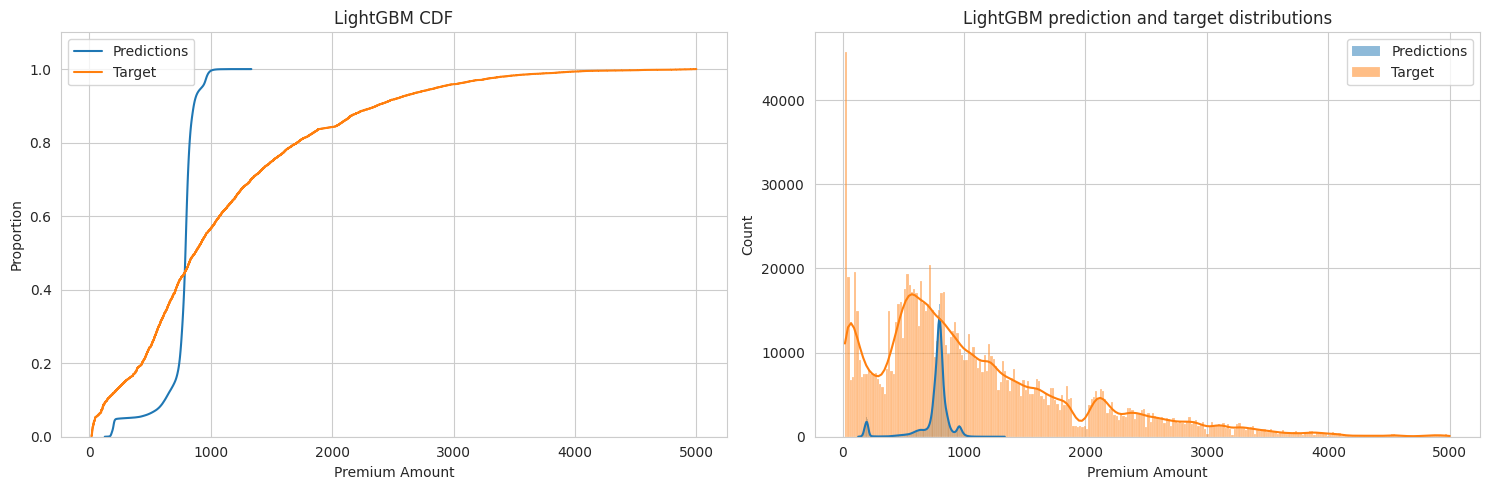

In [13]:
plot_results(oof_preds["LightGBM"], y, "LightGBM")

## LightGBM (GOSS)

In [14]:
X, y, X_test = get_data("lgbm-goss")
lgbm_goss_model = LGBMRegressor(**lgbm_goss_params)
lgbm_goss_trainer = Trainer(lgbm_goss_model)
oof_preds["LightGBM (goss)"], test_preds["LightGBM (goss)"], scores["LightGBM (goss)"], _ = lgbm_goss_trainer.train(X, y, X_test, "lgbm-goss")

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04771	valid_0's l2: 1.0977
[400]	valid_0's rmse: 1.04628	valid_0's l2: 1.09469
[600]	valid_0's rmse: 1.04613	valid_0's l2: 1.09438
[800]	valid_0's rmse: 1.04608	valid_0's l2: 1.09427
[1000]	valid_0's rmse: 1.04605	valid_0's l2: 1.09423
Early stopping, best iteration is:
[995]	valid_0's rmse: 1.04605	valid_0's l2: 1.09422

--- Fold 1 - RMSLE: 1.046049


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04692	valid_0's l2: 1.09603
[400]	valid_0's rmse: 1.04561	valid_0's l2: 1.0933
[600]	valid_0's rmse: 1.0455	valid_0's l2: 1.09306
[800]	valid_0's rmse: 1.04546	valid_0's l2: 1.093
[1000]	valid_0's rmse: 1.04546	valid_0's l2: 1.09298
Early stopping, best iteration is:
[931]	valid_0's rmse: 1.04545	valid_0's l2: 1.09297

--- Fold 2 - RMSLE: 1.045453


Training until validation scores don't improve for 100 rounds
[200]	valid_0's rmse: 1.04773	valid

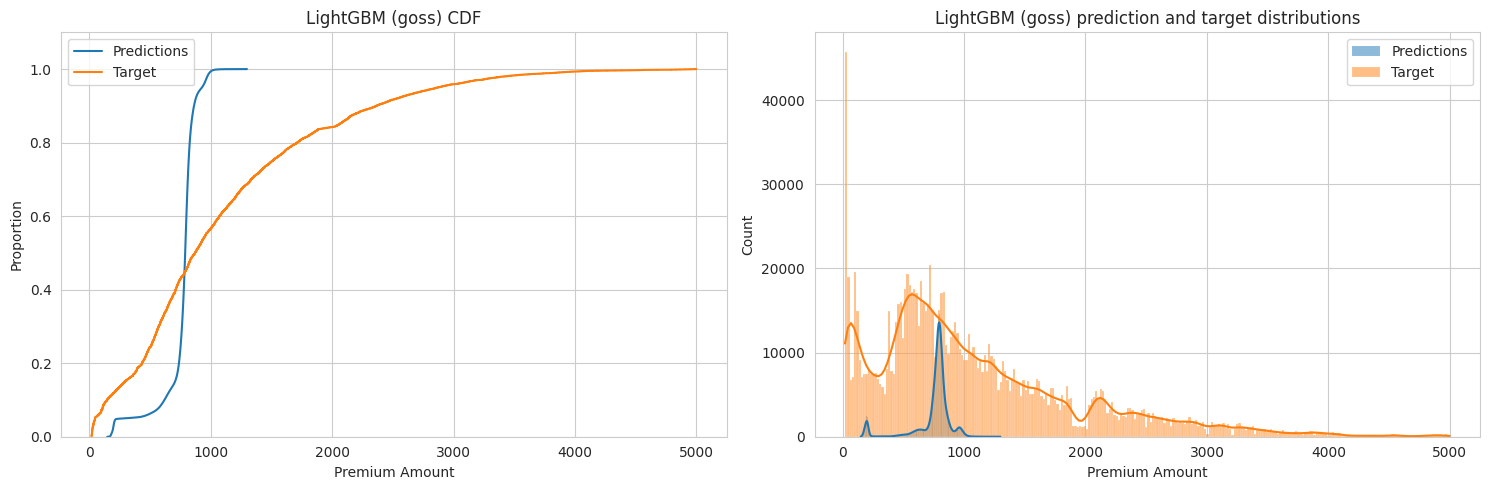

In [15]:
plot_results(oof_preds["LightGBM (goss)"], y, "LightGBM (goss)")

## XGBoost

In [16]:
X, y, X_test = get_data("xgb")
xgb_model = XGBRegressor(**xgb_params)
xgb_trainer = Trainer(xgb_model)
oof_preds["XGBoost"], test_preds["XGBoost"], scores["XGBoost"], _ = xgb_trainer.train(X, y, X_test, "xgb")

Training XGBRegressor

[0]	validation_0-rmse:1.09275
[200]	validation_0-rmse:1.04599
[400]	validation_0-rmse:1.04598
[489]	validation_0-rmse:1.04598

--- Fold 1 - RMSLE: 1.045981


[0]	validation_0-rmse:1.09155
[200]	validation_0-rmse:1.04520
[400]	validation_0-rmse:1.04519
[600]	validation_0-rmse:1.04519
[800]	validation_0-rmse:1.04518
[834]	validation_0-rmse:1.04518

--- Fold 2 - RMSLE: 1.045183


[0]	validation_0-rmse:1.09150
[200]	validation_0-rmse:1.04610
[349]	validation_0-rmse:1.04610

--- Fold 3 - RMSLE: 1.046095


[0]	validation_0-rmse:1.09189
[200]	validation_0-rmse:1.04408
[400]	validation_0-rmse:1.04407
[600]	validation_0-rmse:1.04407
[634]	validation_0-rmse:1.04407

--- Fold 4 - RMSLE: 1.044069


[0]	validation_0-rmse:1.09312
[200]	validation_0-rmse:1.04557
[400]	validation_0-rmse:1.04556
[600]	validation_0-rmse:1.04556
[800]	validation_0-rmse:1.04555
[1000]	validation_0-rmse:1.04555
[1149]	validation_0-rmse:1.04555

--- Fold 5 - RMSLE: 1.045553



------ Overall RMSLE: 1.

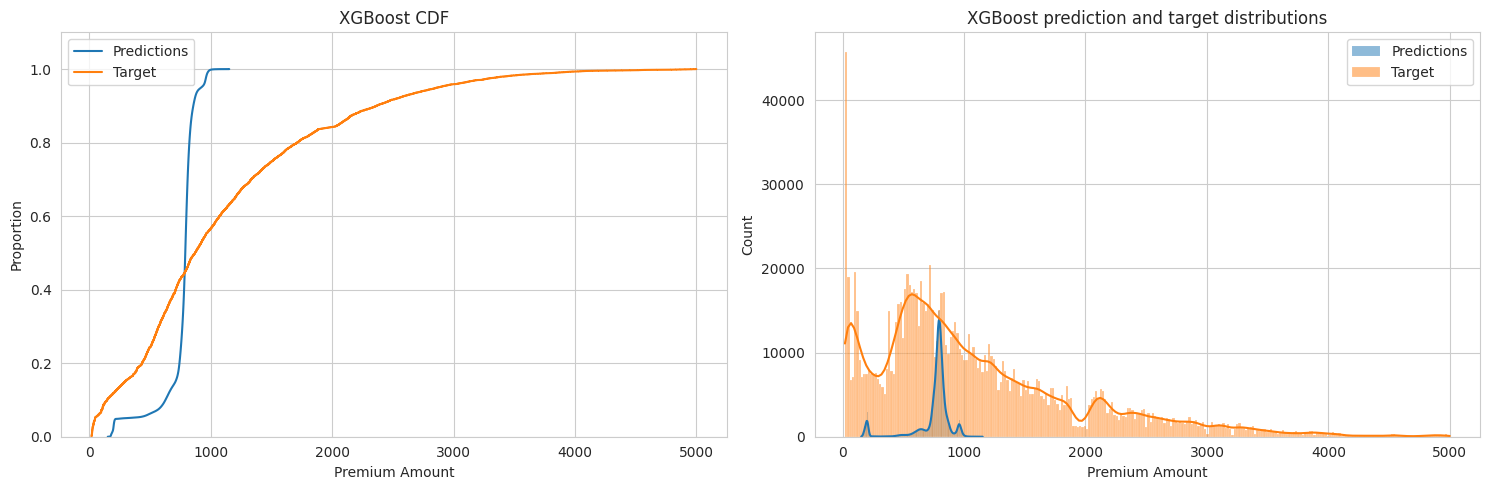

In [17]:
plot_results(oof_preds["XGBoost"], y, "XGBoost")

## CatBoost

In [18]:
X, y, X_test = get_data("cb")
cb_model = CatBoostRegressor(**cb_params)
cb_trainer = Trainer(cb_model)
oof_preds["CatBoost"], test_preds["CatBoost"], scores["CatBoost"], _ = cb_trainer.train(X, y, X_test, "cb")

Training CatBoostRegressor

0:	learn: 1.0901242	test: 1.0909300	best: 1.0909300 (0)	total: 1.34s	remaining: 1h 51m 46s
200:	learn: 1.0461944	test: 1.0479927	best: 1.0479927 (200)	total: 2m 39s	remaining: 1h 3m 37s
400:	learn: 1.0447392	test: 1.0474468	best: 1.0474439 (397)	total: 5m 33s	remaining: 1h 3m 42s
600:	learn: 1.0434487	test: 1.0473216	best: 1.0473197 (575)	total: 8m 41s	remaining: 1h 3m 39s
800:	learn: 1.0417944	test: 1.0472070	best: 1.0471999 (778)	total: 12m	remaining: 1h 2m 57s
1000:	learn: 1.0402240	test: 1.0472071	best: 1.0471743 (925)	total: 15m 20s	remaining: 1h 1m 17s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.047174316
bestIteration = 925

Shrink model to first 926 iterations.

--- Fold 1 - RMSLE: 1.047174


0:	learn: 1.0902007	test: 1.0894791	best: 1.0894791 (0)	total: 1.17s	remaining: 1h 37m 44s
200:	learn: 1.0460910	test: 1.0469186	best: 1.0469186 (200)	total: 2m 52s	remaining: 1h 8m 42s
400:	learn: 1.0444550	test: 1.0463459	best: 1.04634

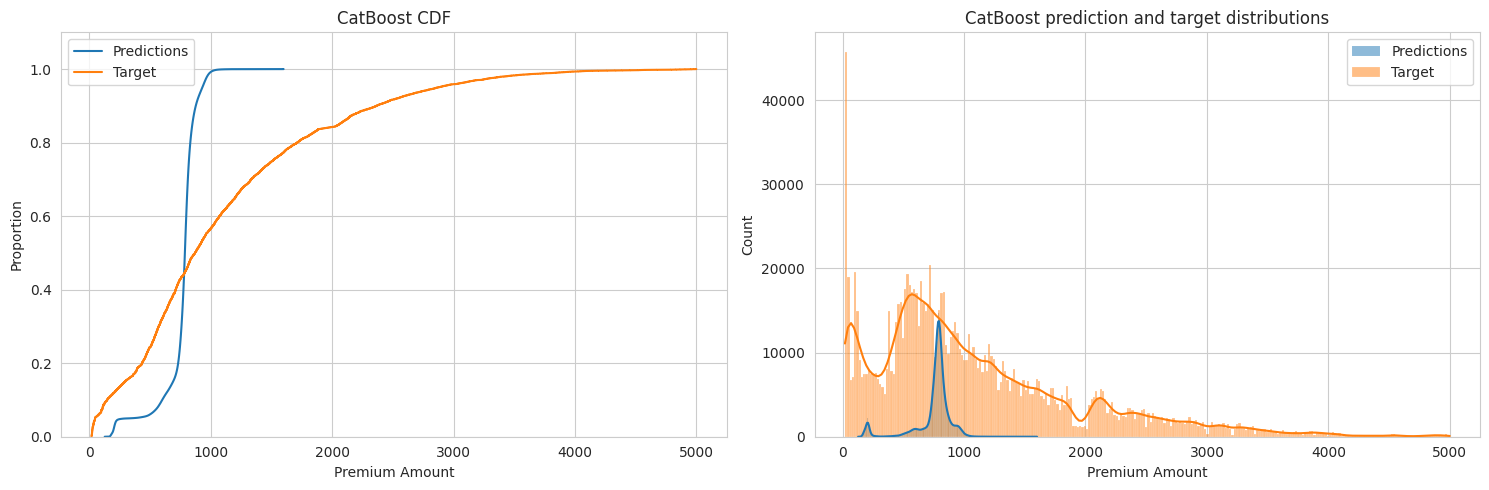

In [19]:
plot_results(oof_preds["CatBoost"], y, "CatBoost")

## Yggdrasil Decision Forests

In [20]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/549959#3064621

def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [21]:
# Reference: https://www.kaggle.com/competitions/playground-series-s4e12/discussion/549959#3064621

X, y, X_test = get_data("ydf")
ydf_model = YDFRegressor(GradientBoostedTreesLearner)(ydf_params)
ydf_trainer = Trainer(ydf_model)
oof_preds["Yggdrasil DF"], test_preds["Yggdrasil DF"], scores["Yggdrasil DF"], _ = ydf_trainer.train(X, y, X_test, "ydf")

Training YDFXRegressor

--- Fold 1 - RMSLE: 1.046125
--- Fold 2 - RMSLE: 1.045586
--- Fold 3 - RMSLE: 1.046284
--- Fold 4 - RMSLE: 1.044083
--- Fold 5 - RMSLE: 1.045777

------ Overall RMSLE: 1.045571 - Average RMSLE: 1.045571


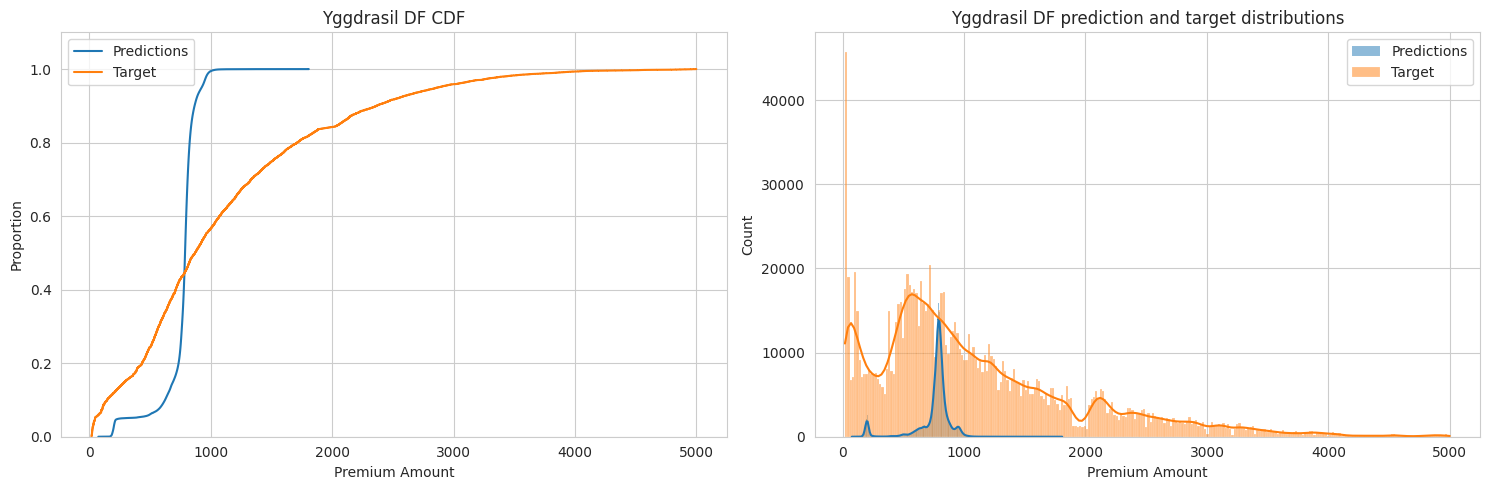

In [22]:
plot_results(oof_preds["Yggdrasil DF"], y, "Yggdrasil DF")

## AutoGluon

In [23]:
oof_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_oof_preds_*.pkl')
test_preds_files = glob.glob(f'/kaggle/input/s04e12-insurance-premium-prediction-autogluon/*_test_preds_*.pkl')

ag_oof_preds = np.log1p(pickle.load(open(oof_preds_files[0], 'rb')))
ag_test_preds = np.log1p(pickle.load(open(test_preds_files[0], 'rb')))

ag_scores = []
split = KFold(n_splits=CFG.n_folds, random_state=CFG.seed, shuffle=True).split(X, y)
for _, val_idx in split:
    y_val = y[val_idx]
    y_preds = ag_oof_preds[val_idx]   
    score = root_mean_squared_error(y_preds, y_val)
    ag_scores.append(score)
    
oof_preds["AutoGluon"], test_preds["AutoGluon"], scores["AutoGluon"] = ag_oof_preds, ag_test_preds, ag_scores

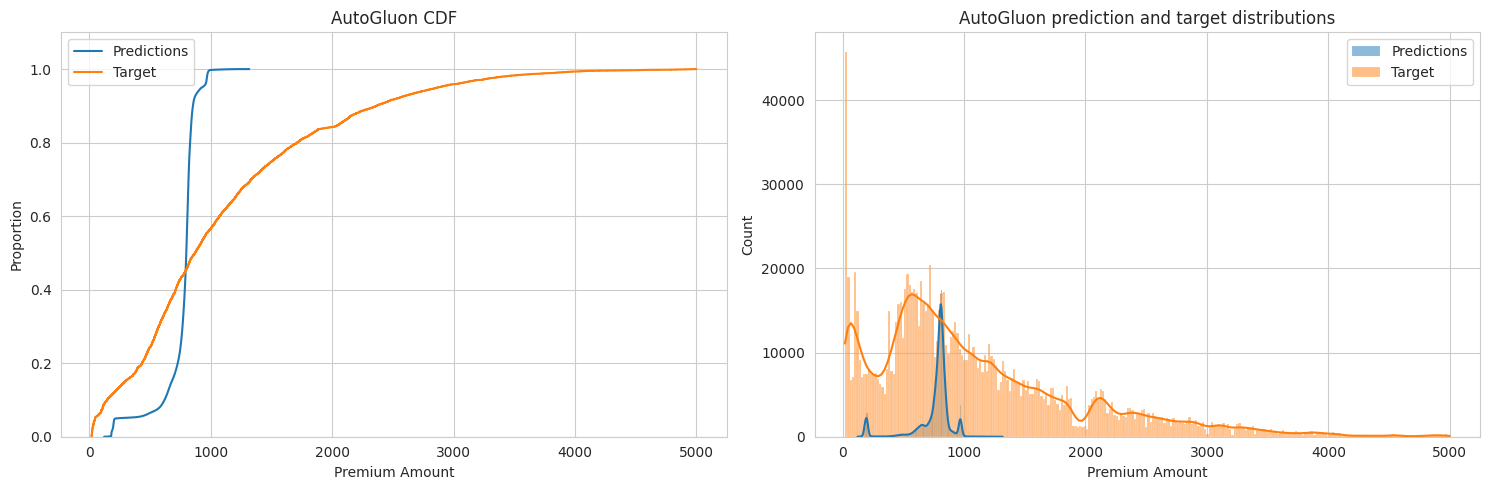

In [24]:
plot_results(oof_preds["AutoGluon"], y, "AutoGluon")

# L2 Ridge

In [25]:
l2_oof_preds = {}
l2_test_preds = {}

In [26]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [27]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [28]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 100),
        'tol': trial.suggest_float('tol', 1e-7, 1e-3)
    }
    
    model = Ridge(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-10 20:23:02,701] A new study created in memory with name: no-name-be993755-a511-499e-a5f9-0c10ef6b86f4
[I 2024-12-10 20:23:10,277] Trial 0 finished with value: 1.044401364622492 and parameters: {'alpha': 90.5737051205064, 'tol': 0.00021468103738635021}. Best is trial 0 with value: 1.044401364622492.
[I 2024-12-10 20:23:10,469] Trial 3 finished with value: 1.0444009312236286 and parameters: {'alpha': 71.20093955521693, 'tol': 0.0002914957863099812}. Best is trial 3 with value: 1.0444009312236286.
[I 2024-12-10 20:23:10,471] Trial 1 finished with value: 1.044400657646453 and parameters: {'alpha': 20.355444410772428, 'tol': 0.0004658986003419867}. Best is trial 1 with value: 1.044400657646453.
[I 2024-12-10 20:23:10,764] Trial 2 finished with value: 1.0444010503896775 and parameters: {'alpha': 77.30880759512526, 'tol': 0.0006718972685906853}. Best is trial 1 with value: 1.044400657646453.
[I 2024-12-10 20:23:17,801] Trial 6 finished with value: 1.0444015852810975 and parameters

In [29]:
ridge_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 35.28350946218756,
  "tol": 2.773133620849139e-05
}


In [30]:
ridge_model = Ridge(**ridge_params)
ridge_trainer = Trainer(ridge_model)
l2_oof_preds["L2 Ensemble Ridge"], l2_test_preds["L2 Ensemble Ridge"], scores["L2 Ensemble Ridge"], ridge_coeffs = ridge_trainer.train(X, y, X_test, "ensemble-ridge")

Training Ridge

--- Fold 1 - RMSLE: 1.044926
--- Fold 2 - RMSLE: 1.044225
--- Fold 3 - RMSLE: 1.045183
--- Fold 4 - RMSLE: 1.042867
--- Fold 5 - RMSLE: 1.044802

------ Overall RMSLE: 1.044401 - Average RMSLE: 1.044401


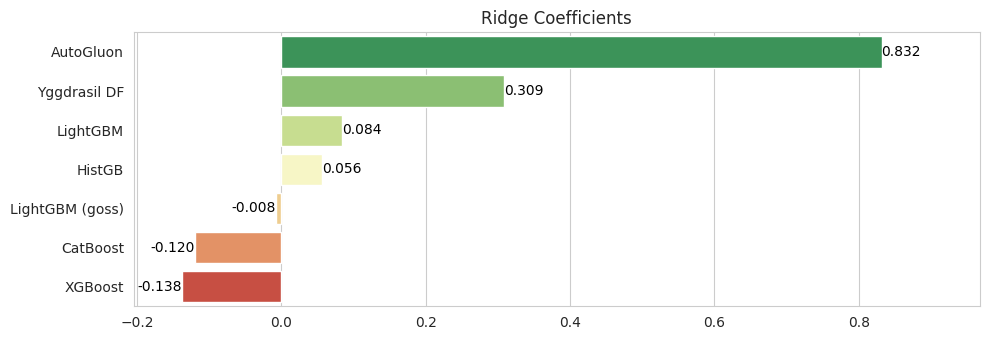

In [31]:
plot_weights(ridge_coeffs, "Ridge Coefficients")

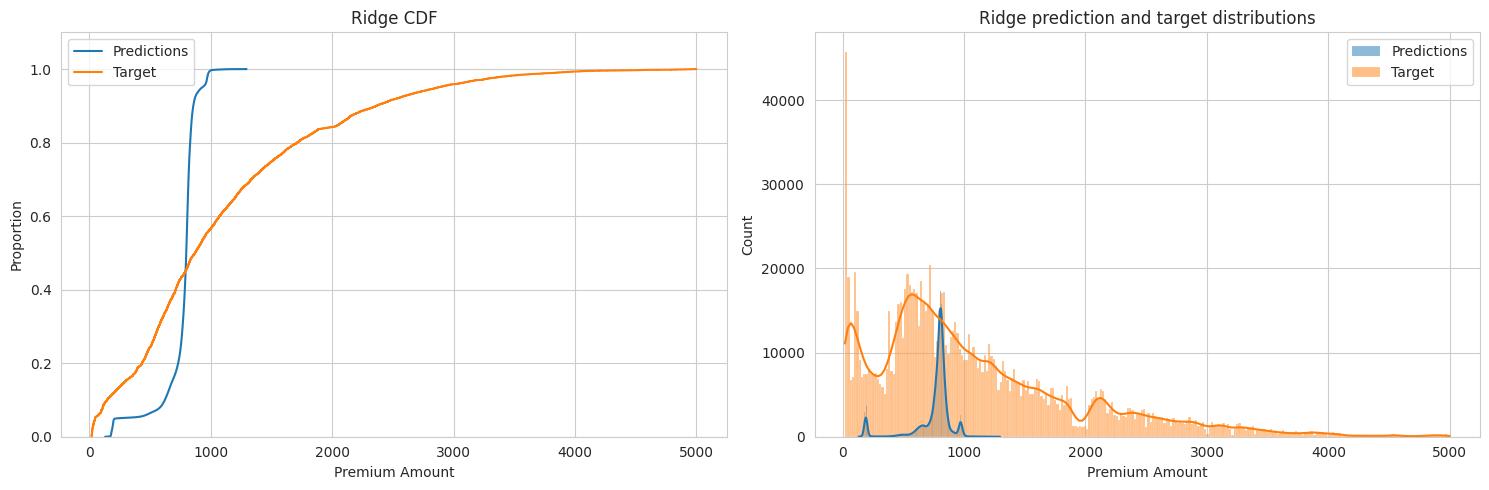

In [32]:
plot_results(l2_oof_preds["L2 Ensemble Ridge"], y, "Ridge")

In [33]:
save_sub("l2-ensemble-ridge", l2_test_preds["L2 Ensemble Ridge"], np.mean(scores["L2 Ensemble Ridge"]))

,id,Premium Amount
0,1200000,813.623667
1,1200001,805.046117
2,1200002,800.712601
3,1200003,816.784649
4,1200004,747.049719
...,...,...
799995,1999995,968.904585
799996,1999996,565.849468
799997,1999997,824.260357
799998,1999998,825.872349


# L2 Lasso

In [34]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [35]:
def objective(trial):    
    params = {
        'random_state': CFG.seed,
        'alpha': trial.suggest_float('alpha', 0, 5),
        'tol': trial.suggest_float('tol', 1e-7, 1e-3)
    }
    
    model = Lasso(**params)
    trainer = Trainer(model)
    return trainer.tune(X, y)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1)
best_params = study.best_params

[I 2024-12-10 20:32:02,858] A new study created in memory with name: no-name-11a918af-e380-4555-a987-10077e2d35c8
[I 2024-12-10 20:32:11,039] Trial 0 finished with value: 1.095826355281642 and parameters: {'alpha': 2.4071556539204786, 'tol': 0.0009876811311643405}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-10 20:32:11,446] Trial 1 finished with value: 1.095826355281642 and parameters: {'alpha': 2.2573315654542485, 'tol': 0.00048483865540565035}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-10 20:32:11,698] Trial 3 finished with value: 1.095826355281642 and parameters: {'alpha': 0.8120743486340243, 'tol': 0.0007169668004742386}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-10 20:32:11,836] Trial 2 finished with value: 1.095826355281642 and parameters: {'alpha': 4.996856699963813, 'tol': 0.0002995720240228547}. Best is trial 0 with value: 1.095826355281642.
[I 2024-12-10 20:32:19,863] Trial 5 finished with value: 1.095826355281642 and parameters:

In [36]:
lasso_params = {
    'random_state': CFG.seed,
    'alpha': best_params['alpha'],
    'tol': best_params['tol']
}
print(json.dumps(lasso_params, indent=2))

{
  "random_state": 42,
  "alpha": 0.0003918090042550112,
  "tol": 0.000401578663871083
}


In [37]:
lasso_model = Lasso(**lasso_params)
lasso_trainer = Trainer(lasso_model)
l2_oof_preds["L2 Ensemble Lasso"], l2_test_preds["L2 Ensemble Lasso"], scores["L2 Ensemble Lasso"], lasso_coeffs = lasso_trainer.train(X, y, X_test, "ensemble-ridge")

Training Lasso

--- Fold 1 - RMSLE: 1.044983
--- Fold 2 - RMSLE: 1.044226
--- Fold 3 - RMSLE: 1.045197
--- Fold 4 - RMSLE: 1.042918
--- Fold 5 - RMSLE: 1.044802

------ Overall RMSLE: 1.044426 - Average RMSLE: 1.044425


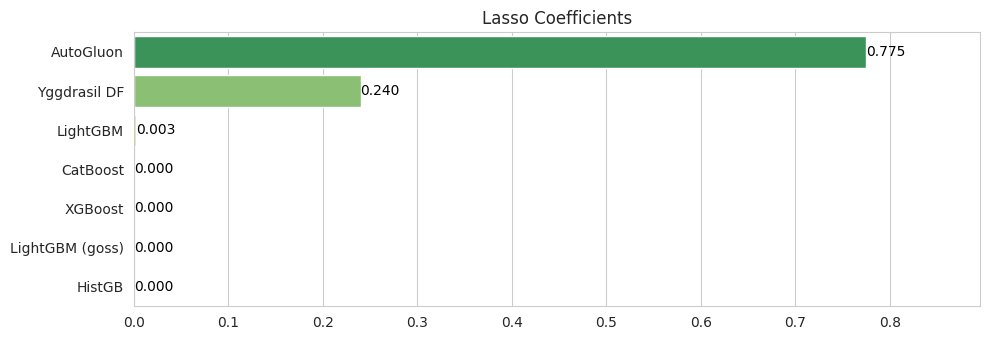

In [38]:
plot_weights(lasso_coeffs, "Lasso Coefficients")

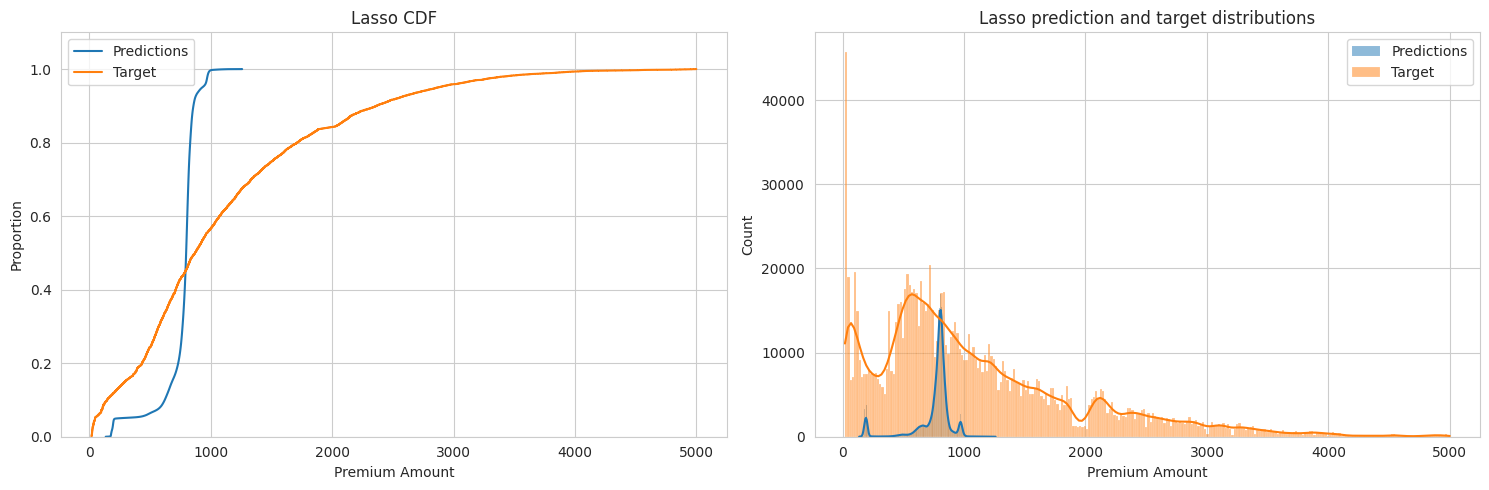

In [39]:
plot_results(l2_oof_preds["L2 Ensemble Lasso"], y, "Lasso")

In [40]:
save_sub("l2-ensemble-lasso", l2_test_preds["L2 Ensemble Lasso"], np.mean(scores["L2 Ensemble Lasso"]))

,id,Premium Amount
0,1200000,803.274055
1,1200001,804.722009
2,1200002,801.757017
3,1200003,815.080882
4,1200004,746.429804
...,...,...
799995,1999995,967.998919
799996,1999996,563.715780
799997,1999997,822.768267
799998,1999998,822.918545


# L3 weighted ensemble

In [41]:
def objective(trial):
    weights = np.array([trial.suggest_float(l2_model_name, 0, 1) for l2_model_name in l2_oof_preds.keys()])
    weights /= np.sum(weights)
    
    preds = np.zeros(len(y))
    for model, weight in zip(l2_oof_preds.keys(), weights):
        preds += l2_oof_preds[model] * weight
            
    return root_mean_squared_error(y, preds)

sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=CFG.n_optuna_trials * 2, n_jobs=-1)

[I 2024-12-10 20:51:39,211] A new study created in memory with name: no-name-1537f5da-daec-40eb-b56c-070424867d9f
[I 2024-12-10 20:51:39,280] Trial 0 finished with value: 1.0444166932683163 and parameters: {'L2 Ensemble Ridge': 0.14801442524229436, 'L2 Ensemble Lasso': 0.6842083710377155}. Best is trial 0 with value: 1.0444166932683163.
[I 2024-12-10 20:51:39,286] Trial 1 finished with value: 1.0444040807658568 and parameters: {'L2 Ensemble Ridge': 0.8573198377294325, 'L2 Ensemble Lasso': 0.6738608972719837}. Best is trial 1 with value: 1.0444040807658568.
[I 2024-12-10 20:51:39,288] Trial 2 finished with value: 1.0444050097772535 and parameters: {'L2 Ensemble Ridge': 0.9929148060326622, 'L2 Ensemble Lasso': 0.9228868568914553}. Best is trial 1 with value: 1.0444040807658568.
[I 2024-12-10 20:51:39,292] Trial 3 finished with value: 1.0444022144105058 and parameters: {'L2 Ensemble Ridge': 0.8506625078639468, 'L2 Ensemble Lasso': 0.42776330257731965}. Best is trial 3 with value: 1.044402

In [42]:
scores['L3 Weighted Ensemble'] = [study.best_value] * CFG.n_folds

In [43]:
best_weights = np.array([study.best_params[l2_model] for l2_model in l2_oof_preds.keys()])
best_weights /= np.sum(best_weights)
print(json.dumps({model: weight for model, weight in zip(l2_oof_preds.keys(), best_weights)}, indent=2))

{
  "L2 Ensemble Ridge": 0.8943891166570436,
  "L2 Ensemble Lasso": 0.10561088334295637
}


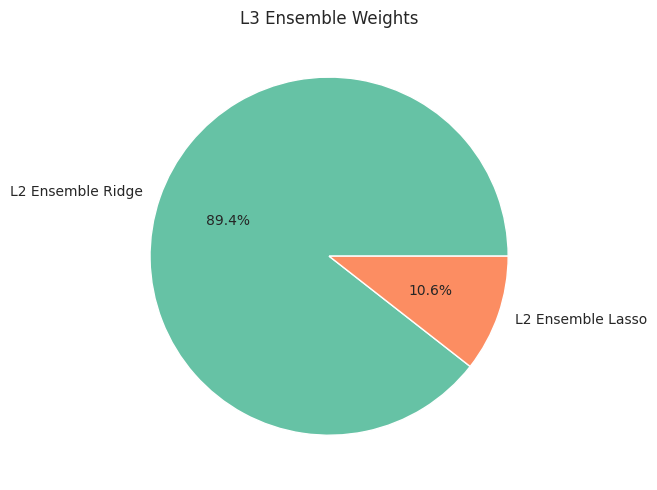

In [44]:
plt.figure(figsize=(8, 5))
plt.pie(
    study.best_params.values(), 
    labels=study.best_params.keys(), 
    autopct='%1.1f%%',
    colors=sns.color_palette('Set2', 2)
)
plt.title("L3 Ensemble Weights")
plt.tight_layout()
plt.show()

In [45]:
weighted_test_preds = np.zeros((X_test.shape[0]))
for model, weight in zip(l2_test_preds.keys(), best_weights):
    weighted_test_preds += l2_test_preds[model] * weight
    
save_sub('l3-weighted-ensemble', weighted_test_preds, np.mean(scores['L3 Weighted Ensemble']))

,id,Premium Amount
0,1200000,812.524375
1,1200001,805.011882
2,1200002,800.822838
3,1200003,816.604545
4,1200004,746.984225
...,...,...
799995,1999995,968.808897
799996,1999996,565.623747
799997,1999997,824.102648
799998,1999998,825.559896


# Results

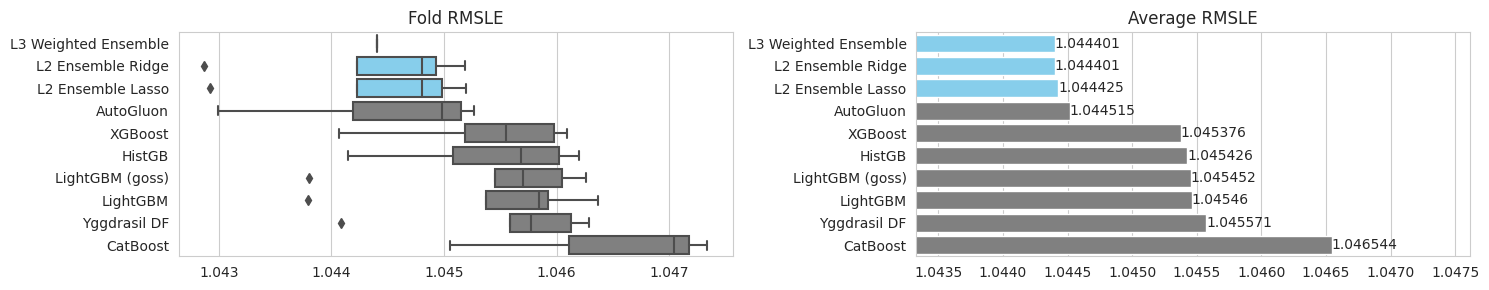

In [46]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "skyblue" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

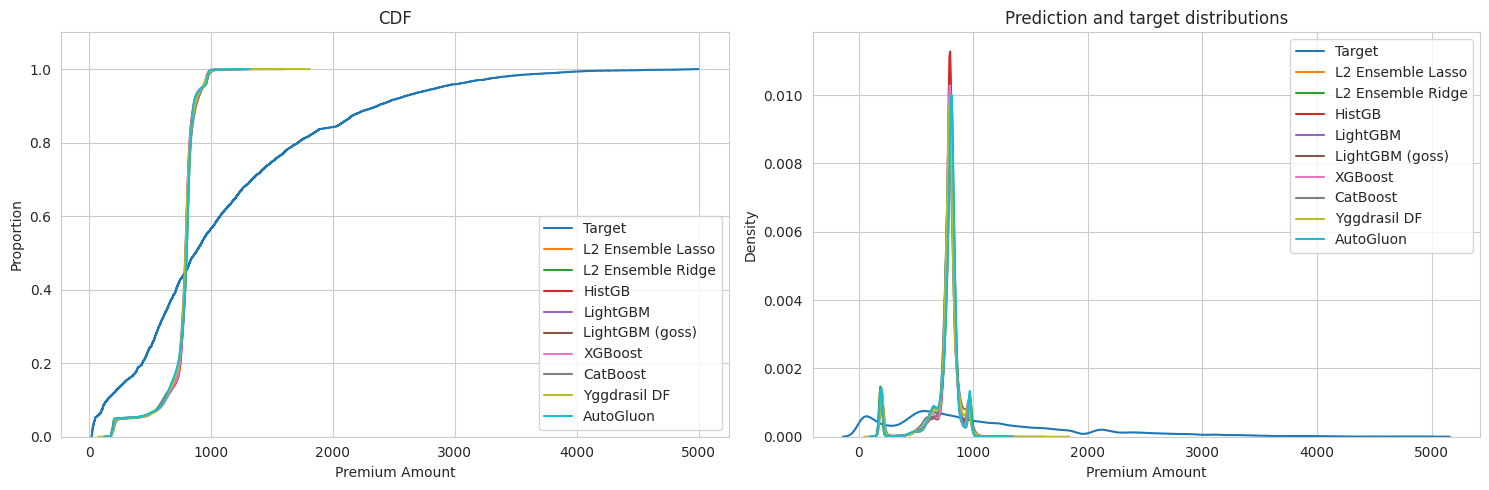

In [47]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.ecdfplot(np.expm1(y), label="Target", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), label="L2 Ensemble Lasso", ax=axes[0])
sns.ecdfplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), label="L2 Ensemble Ridge", ax=axes[0])
for model in oof_preds:
    sns.ecdfplot(np.expm1(oof_preds[model]), label=model, ax=axes[0])
axes[0].set_title("CDF")
axes[0].legend(loc="best")
axes[0].set_ylim(0, 1.1)

sns.kdeplot(np.expm1(y), ax=axes[1], label='Target')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Lasso"]), ax=axes[1], label='L2 Ensemble Lasso')
sns.kdeplot(np.expm1(l2_oof_preds["L2 Ensemble Ridge"]), ax=axes[1], label='L2 Ensemble Ridge')
for model in oof_preds:
    sns.kdeplot(np.expm1(oof_preds[model]), ax=axes[1], label=model)
axes[1].set_title("Prediction and target distributions")
axes[1].legend(loc="best")

plt.tight_layout()
plt.show()

In [48]:
shutil.rmtree("catboost_info", ignore_errors=True)